# 2 Gradient decent methods


We re-use the quadratic function from last exercise $f: \mathcal{R}^2 \rightarrow \mathcal{R}$ defined as 

$$
f(\mathbf{x}) = (\mathbf{x} - \tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x} - \tilde{\mathbf{x}})
$$
with 
$$
\mathbf{Q} = 
\begin{pmatrix}
    2 & 1 \\
    1 & 1 
\end{pmatrix} 
\quad 
\text{and}
\quad
\tilde{\mathbf{x}} = 
\begin{pmatrix}
    -1\\
    1 
\end{pmatrix}
$$
to test the implemented gradient decent methods.

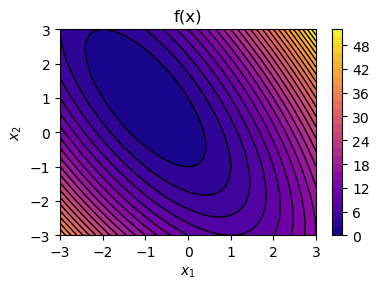

In [404]:
import torch
from utils import plot_contours 

# Define domain
x0 = torch.linspace(-3, 3, steps=100)
x1 = torch.linspace(-3, 3, steps=100)
x = torch.stack(torch.meshgrid(x0, x1, indexing='xy'), dim=2)

# Define constants
xt = torch.tensor([-1., 1.])
Q = torch.tensor([[2., 1.],[1, 1.]])

# Define function
def f(x):
    dx = x - xt
    return  torch.einsum("...i,ij,...j", dx, Q, dx)

plot_contours(x[:,:,0], x[:,:,1], f(x), title="f(x)")

## Task 1 - Simple steepest decent

We have a predfined function named `simple_decent(x_init, func, eta=0.1, maxiter=10)` that takes an intial point $\mathbf{x}_0 \in \mathcal{R}^d$ named `x_init`, a function `func`, a step size `eta` with a default value of 0.1 and an iteration limit `max_iter` with a default value 100. Implement a simple steepest gradient decent in that function. The function should return a list of all steps $\mathbf{x}_k \in \mathcal{R}^d$ taken during the optimization, i.e. `[[x1_0, x2_0, ..., xd_0], [x1_1, x2_1, ..., xd_1], ...]`

In [405]:
def simple_decent(x_init, func, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()

    points = []
    for _ in range(max_iter):
        # Save intermediate results
        points.append([xi.item() for xi in x])
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Make a step
        x.data -= eta * grad

    return points

Test the function with the following code for 
$$
    \mathbf{x}_0 = 
\begin{pmatrix}
    2\\
    -1 
\end{pmatrix}
$$
and play around with the number of iterations or step size. 

Final values are x_1=-0.999, x_2=0.999


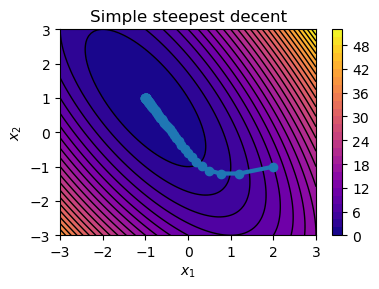

In [406]:
x_init = torch.tensor([2.,-1.])
path = simple_decent(x_init, f)
plot_contours(x[:,:,0], x[:,:,1], f(x), title="Simple steepest decent", paths=[path])
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")

## Task 2 - Steepest decent method with incomplete line search

In [407]:
def line_search_decent(x_init, func, eta_0=1.0, c=0.001, rho=0.5, max_iter=10):
    x = x_init.clone().requires_grad_()

    points = []
    for _ in range(max_iter):
        # Save intermediate results
        points.append([xi.item() for xi in x])
        # Compute direction
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        grad_norm = grad.norm()
        p = - grad / grad_norm
        # Backtracking algorithm
        eta = eta_0
        while func(x + eta*p) > func(x) + c * eta * torch.dot(grad, p):
            eta *= rho
        # Make a step
        x.data += eta * p

    return points

Final values are x_1=-0.954, x_2=0.979


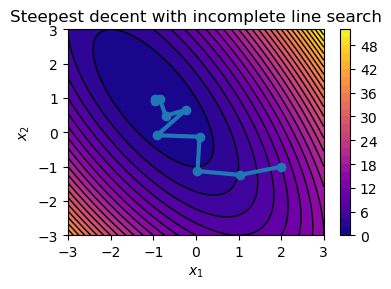

In [408]:
x_init = torch.tensor([2.,-1.])
path = line_search_decent(x_init, f)
plot_contours(x[:,:,0], x[:,:,1], f(x), title="Steepest decent with incomplete line search", paths=[path])
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")

## Task 3 - Conjugated gradients

In [409]:
def cg_decent(x_init, func, c=0.001, rho=0.5, max_iter=5):
    x = x_init.clone().requires_grad_()

    points = []
    for i in range(max_iter):
        points.append([xi.item() for xi in x])
        # Compute gradient
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        # Compute conjugated direction
        if i > 0:
            beta = torch.dot(grad,grad) / torch.dot(grad_old, grad_old)
            p = - grad + beta*p_old
        else:
            p = - grad
        # Solve subproblem with simple gradient decent
        eta_0 = torch.tensor([1.])
        etas = line_search_decent(eta_0, lambda eta : f(x + eta*p))
        # Make a step
        x.data += etas[-1][0] * p
        # Store gradients 
        grad_old = grad
        p_old = p 

    return points

Final values are x_1=-1.000, x_2=1.000


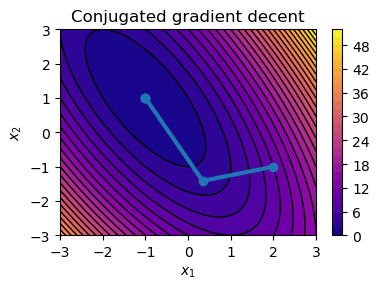

In [410]:
x_init = torch.tensor([2.,-1.])
path = cg_decent(x_init, f)
plot_contours(x[:,:,0], x[:,:,1], f(x), title="Conjugated gradient decent", paths=[path])
print(f"Final values are x_1={path[-1][0]:.3f}, x_2={path[-1][1]:.3f}")